2023-12-12 Meeting

- Use click rate everywhere
- Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression
- Make Regplot https://seaborn.pydata.org/generated/seaborn.regplot.html - should expect a clear upwards trend
- Taking the predictions of the correlational model and compare the top and least rated

In [1]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.linear_model import RidgeCV, LogisticRegression, LinearRegression
from torch.utils.data import DataLoader, TensorDataset
import csv
import torch 
import pickle
import random
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr
import math
import shap
import langid


In [2]:
#cpu/gpu
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

No GPU available, using the CPU instead.


In [36]:
#Load data
df = pd.read_csv("upworthy-archive-confirmatory-packages-03.12.2020.csv", low_memory=False)
#adding index
df.reset_index(inplace=True,names=["embedding_id"])

#remove rows without eyecatcher_id (about 100)
has_eyecatcher_id = df['eyecatcher_id'].notna()
df = df.loc[has_eyecatcher_id]
#Create a new column for clickrate
df["clickrate"] = round((df["clicks"]/ df["impressions"]), ndigits=10)

#filter data based on same clickability_id and eyecatcher_id
df['headline_count'] = df.groupby(['clickability_test_id', 'eyecatcher_id']).headline.transform('count')
df.columns
# filter for all headlines with at least 2 pairs. 
df = df.loc[df['headline_count']>=2, ['clickability_test_id', 'excerpt', 'headline', 'lede', 'eyecatcher_id', 'clicks', 'headline_count',"embedding_id","clickrate","impressions"]]

# drop all rows with same headline,clickability_test_id and eyecatcher_id

df = df.drop_duplicates(subset=["headline","clickability_test_id","eyecatcher_id"],keep=False)
#checking if it was successful
print(df[df["clickability_test_id"] == "546de9399ad54eca4800003c"]) #this is an example of matching headline, clickability test id and eyecatcher id
df = df.sort_values(by='headline_count', ascending=False)
#print(df.head())
#checking if there are any duplicates
#df = df.drop_duplicates(subset=["headline"]) ##this was before
##this is a new version
dupl_headline = df[df.duplicated(subset=["headline"])] #here we want to keep one of the duplicates

#duplicated = df[dupl_headline]
ids = dupl_headline["clickability_test_id"]

mask = df['clickability_test_id'].isin(ids)
df = df[~mask]
print(df.shape) #too few observations :(
#print(df[df["clickability_test_id"] == "545181f8763e26efef000001"]) #those are staying because there are a lot of observations
#print(df[df["clickability_test_id"] == "54518b6da54be28ef000000b"]) #those are not staying because there a less packages within the test than then in the one above


Empty DataFrame
Columns: [clickability_test_id, excerpt, headline, lede, eyecatcher_id, clicks, headline_count, embedding_id, clickrate, impressions]
Index: []
(34646, 10)
           clickability_test_id  \
82808  541dd09b88aa4b01c3000001   
82811  541dd09b88aa4b01c3000001   
82818  541dd09b88aa4b01c3000001   
82817  541dd09b88aa4b01c3000001   
63717  534a0b4e55c9d331f2000019   
...                         ...   
27235  51526be712fc670002007e99   
27228  514b5f8c557d62000200040a   
68403  53a8e50f7bb5bc1273000062   
9177   550ce47b6366610024eb0000   
9179   550ce47b6366610024eb0000   

                                                 excerpt  \
82808                   Things that matter. Pass 'em on.   
82811                   Things that matter. Pass 'em on.   
82818                   Things that matter. Pass 'em on.   
82817                   Things that matter. Pass 'em on.   
63717     Things that matter. Pass 'em on. #PromotedPost   
...                                            

In [4]:
#Checking for spanish headlines
headlines = df['headline'].astype(str).tolist()
results = [langid.classify(headline) for headline in headlines]
log_file = "output_log.txt"

with open(log_file, "w", encoding="utf-8") as log:
    for headline,result in zip(headlines,results):
        language = result
       
        log.write(f"Sentence: {headline}, Identified Language: {language}\n")
#doesnt work amazingly for some reason and it just outputs all the sentences. The spanish ones are:
#Como Decir Todo … Sin Pronunciar Ninguna Palabra
#Ve La Protesta Que Todos Deben Conocer, Pero Que Nadie Puede Oir
#En Vez De ‘Sí Se Puede,’ Ya Es ‘Sí Se Shhhhhhhhh’?
#¿Cómo Se Dice ‘Nada’ En Español?
#all of them have the same clickability_id, so I would just remove them, because they are basically one experiment
print(df.shape)
df = df[df["clickability_test_id"] != "51436075220cb800020007b3"]
#checking if i dropped exactly 4
print(df.shape)

(47096, 10)
(47092, 10)


In [5]:
# Make tensor
clickrate = torch.tensor(df.clickrate.values)

In [6]:
print(df.groupby(["clickability_test_id"]).count().mean()) #average of 3.5 packages within one test
print(df.groupby(["clickability_test_id","eyecatcher_id"]).count().mean()) #average of 3.5 packages with the same eyecatcher id and same clickability_test_id
df.head()

excerpt           3.072195
headline          3.483394
lede              3.481397
eyecatcher_id     3.483394
clicks            3.483394
headline_count    3.483394
embedding_id      3.483394
clickrate         3.483394
impressions       3.483394
dtype: float64
excerpt           3.040261
headline          3.447185
lede              3.445209
clicks            3.447185
headline_count    3.447185
embedding_id      3.447185
clickrate         3.447185
impressions       3.447185
dtype: float64


,clickability_test_id,excerpt,headline,lede,eyecatcher_id,clicks,headline_count,embedding_id,clickrate,impressions
82816,541dd09b88aa4b01c3000001,Things that matter. Pass 'em on.,What’s Funny About Environmentalism? I Used To...,<p>LIGHTBULB MOMENT: I think I figured out wha...,541dd246f509e102bb000005,22,17,82816,0.005313,4141
82819,541dd09b88aa4b01c3000001,Things that matter. Pass 'em on.,"Damn, Sun. Brother Earth Is About To Send His ...",<p>LIGHTBULB MOMENT: I think I figured out wha...,541dd246f509e102bb000005,11,17,82819,0.002601,4229
62711,534a0b4e55c9d331f2000019,Things that matter. Pass 'em on. #PromotedPost,Watch This Ridiculously Cute And Uplifting Vid...,<p>The world can be a tough place sometimes fo...,5349d78bcef1f1e528000017,27,17,62711,0.012931,2088
34575,534a0b4e55c9d331f2000019,Things that matter. Pass 'em on. #PromotedPost,Watch This Ridiculously Cute And Uplifting Vid...,<p>The world can be a tough place sometimes fo...,5349d78bcef1f1e528000017,21,17,34575,0.010140,2071
14325,534a0b4e55c9d331f2000019,Things that matter. Pass 'em on. #PromotedPost,Watch This Ridiculously Cute And Uplifting Vid...,<p>The world can be a tough place sometimes fo...,5349d78bcef1f1e528000017,24,17,14325,0.011289,2126


In [7]:
#Load prerun embeddings of all-mpnet-base-v2
with open('upd_all-mpnet-base-v2_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['headlines']
    stored_embeddings = stored_data['embeddings']
    
#remove rows without eyecatcher_id
#stored_sentences = stored_sentences[has_eyecatcher_id]
#stored_embeddings = stored_embeddings[has_eyecatcher_id]

## 1.1 Predicting clickrate from headline embeddings with Ridge regression


In [8]:
# Model

X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clickrate, test_size=0.2)

In [9]:
# Ridge Model
ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model.fit(X_train, y_train)
ridge_model.score(X_train,y_train)
predictions = ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions)
print("Ridge Regression MSE for click difference:", rmse)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions_ridge"] = ridge_model.predict(stored_embeddings)

Ridge Regression MSE for click difference: 9.976231746092919e-05
Ridge Regression R2 for click difference: 0.21986141911318902


## 1.2 Predicting clickrate from headline embeddings with Linear regression

In [10]:
# Linear Model
linear_model =LinearRegression()
linear_model.fit(X_train, y_train)
linear_model.score(X_train,y_train)
predictions = linear_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Linear Regression MSE for clicks:", rmse)
print("Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions_linear"] = linear_model.predict(stored_embeddings)

Linear Regression MSE for clicks: 0.010221529232721634
Linear Regression R2 for clicks: 0.18297193123007505


## 1.3 Visualizing predicted clicks vs actual clicks

0.03457588018265298


[Text(0, 0.5, 'true clickrate'), Text(0.5, 0, 'predicted clickrate')]

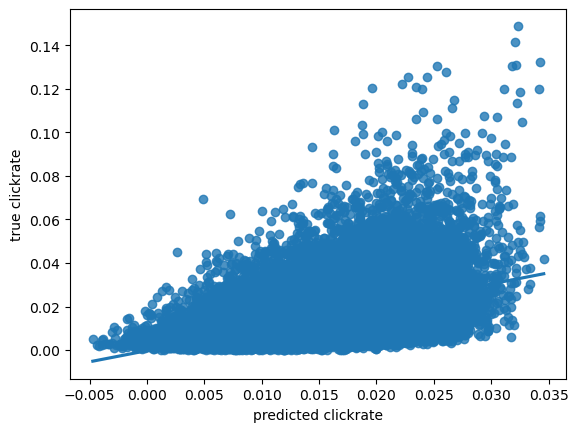

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# print stuff. 
predictions = ridge_model.predict(stored_embeddings)
print(predictions.max())
# visualize real and predicted values
fig, ax = plt.subplots()
sns.regplot(x = predictions, y = df.clickrate, ax=ax)
ax.set(ylabel = 'true clickrate', xlabel = 'predicted clickrate')

## 2.Causal Model 

Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression

In [12]:
#calculating mean per clickability_test_id and eyecatcher_id
df["means"] = df.groupby(["clickability_test_id","eyecatcher_id"])["clickrate"].transform("mean")
df.columns
df["adjusted_clickrate"] = df["clickrate"]/df["means"]
# set rows with 0 clicks -> adjusted clickrates NA - set to zero
df["adjusted_clickrate"] = df["adjusted_clickrate"].fillna(0)
print(df["adjusted_clickrate"].isna().sum())
adjusted_clickrate = torch.tensor(df.adjusted_clickrate.values)

0


In [13]:
# What do we do with headlines that did not get any clicks? 
# Will they just have an adjusted clickrate of zero?
df.loc[(df["clickrate"]/df["means"]).isna(), ['headline', 'eyecatcher_id', 'clicks', 'impressions', 'means', 'clickrate']]

,headline,eyecatcher_id,clicks,impressions,means,clickrate
11156,"8 Facts about vaccines: How they work, who's g...",5533f71a3561320024220000,0,1959,0.0,0.0
9940,This is what deforestation can do to your city...,54f6266f32356100265f0100,0,1983,0.0,0.0
9277,A really cool animation about food and what yo...,5508d167613334000c1b0000,0,2034,0.0,0.0
31722,"Hey Barack, We're Blowing Billions On Busting ...",5332bbcc1fae79f09f0058d7,0,53,0.0,0.0


## 2.1 Causal model with Ridge Regression 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, adjusted_clickrate, test_size=0.2)
causal_ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
causal_ridge_model.fit(X_train, y_train)
causal_ridge_model.score(X_train,y_train)
causal_predictions_rg = causal_ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, causal_predictions_rg)
print("Causal Ridge Regression MSE for click difference:", rmse)
print("Causal Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=causal_predictions_rg))
df["causal_predictions_ridge"] = causal_ridge_model.predict(stored_embeddings)

Causal Ridge Regression MSE for click difference: 0.07932103415548808
Causal Ridge Regression R2 for click difference: 0.04966454672948639


## 2.2 Causal model with Linear Regression

Causal Linear Regression MSE for clicks: 0.2829956489619514
Causal Linear Regression R2 for clicks: 0.0404931483053248


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='causal_predictions_linear', ylabel='Count'>

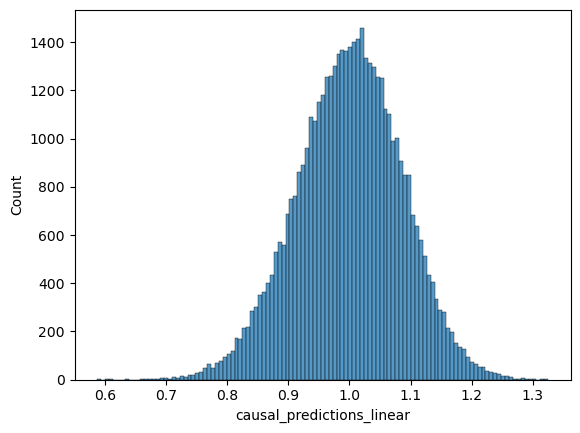

In [15]:
causal_linear_model =LinearRegression()
causal_linear_model.fit(X_train, y_train)
causal_linear_model.score(X_train,y_train)
causal_predictions_lm = causal_linear_model.predict(X_test)
rmse = mean_squared_error(y_test, causal_predictions_lm, squared=False)
print("Causal Linear Regression MSE for clicks:", rmse)
print("Causal Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=causal_predictions_lm))
df["causal_predictions_linear"] = causal_linear_model.predict(stored_embeddings)
sns.histplot(df["causal_predictions_linear"])

## 3.1 Compare top / bottom 20 causal model with correlational model - Ridge Regression


In [16]:
from ipywidgets import widgets, Layout
from IPython import display


last20_pred = df.sort_values(["predictions_ridge"],ascending=True).loc[:,['headline']][:20]
last20_pred_causal = df.sort_values(["causal_predictions_ridge"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Ridge'))
    last20_pred.info()
with widget2:
    display.display(last20_pred_causal.style.set_caption('Last 20 Causal'))
    last20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [17]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_pred_causal.values)

array(["Can We Make Space To Hear People's Stories, Or Are Corporations The Only Ones With A Voice?",
       'How To Change Lives? Partnership. Encouragement. Good Pens.',
       'You Know What Gets Bi-Partisan Support? Not Being Corrupt And Working Together. By A 2-1 Margin.'],
      dtype=object)

In [18]:
first20_pred = df.sort_values(["predictions_ridge"],ascending=False).loc[:,['headline']][:20]
first20_pred_causal = df.sort_values(["causal_predictions_ridge"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(first20_pred.style.set_caption('First 20 Ridge'))
    first20_pred.info()
with widget2:
    display.display(first20_pred_causal.style.set_caption('First 20 Causal'))
    first20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [19]:
np.intersect1d(first20_pred.values,first20_pred_causal.values)

array([], dtype=object)

In [20]:
df["predictions_linear"]

82816    0.008171
82819    0.009658
62711    0.014826
34575    0.015388
14325    0.015793
           ...   
85277    0.021562
14232    0.014101
27228    0.020086
91177    0.007632
44283    0.009050
Name: predictions_linear, Length: 47092, dtype: float32

## 3.1 Compare top / bottom 20 causal model with correlational model - Linear

In [21]:
last20_pred = df.sort_values(["predictions_linear"],ascending=True).loc[:,['headline']][:20]
last20_pred_causal = df.sort_values(["causal_predictions_linear"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Linear'))
    last20_pred.info()
with widget2:
    display.display(last20_pred_causal.style.set_caption('Last 20 Causal'))
    last20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [22]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_pred_causal.values)

array(["Can We Make Space To Hear People's Stories, Or Are Corporations The Only Ones With A Voice?"],
      dtype=object)

In [23]:
first20_pred = df.sort_values(["predictions_linear"],ascending=False).loc[:,['headline']][:20]
first20_pred_causal = df.sort_values(["causal_predictions_linear"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(first20_pred.style.set_caption('First 20 Linear'))
    first20_pred.info()
with widget2:
    display.display(first20_pred_causal.style.set_caption('First 20 Causal'))
    first20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [24]:
#Checking for intersection
np.intersect1d(first20_pred.values,first20_pred_causal.values)

array([], dtype=object)

## 4.1 Shapley Values Ridge Regression predicting Clickrate

In [25]:
# load the model

# here we also need embeddings - the whole thing is our model
model = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2")

# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    embedding = model.encode(x)
    return ridge_model.predict(embedding)

In [26]:
#defining masker - the masker specifies how to hide portions of the input
method = "default masker" #before it was custo tokenizer, but it works the same with the default one so i would say remove everything and just leave the defining of the whitespace masker

# build an explainer by passing a transformers tokenizer
if method == "transformers tokenizer":
    explainer = shap.Explainer(f)

# build an explainer by explicitly creating a masker
elif method == "default masker":
    masker  = shap.maskers.Text("\W|'")   # this will create a basic whitespace tokenizer.
    #A whitespace tokenizer breaks a text into tokens based on whitespace characters (spaces, tabs, newlines,/, etc.)
    explainer = shap.Explainer(f, masker)



### 4.1.1 Checking Shap values for top 20 predictions made with ridge

In [27]:
top_values = df.sort_values(["predictions_ridge"],ascending=False).loc[:,['headline']][:20]
#removing duplicates, so they dont influence the overall 
top_values = top_values.drop_duplicates(keep='first')
top_shap_values_ridge = explainer(top_values["headline"])


  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|███                                                          | 1/20 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██████████▌                                          | 4/20 [00:22<00:59,  3.75s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|█████████████▎                                       | 5/20 [00:35<01:47,  7.18s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|█████████████████████▏                               | 8/20 [00:53<01:10,  5.90s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|██████████████████████████                          | 10/20 [01:09<01:04,  6.46s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|███████████████████████████████▏                    | 12/20 [01:17<00:42,  5.28s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|█████████████████████████████████████████▌          | 16/20 [01:36<00:19,  4.91s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|██████████████████████████████████████████████▊     | 18/20 [01:52<00:12,  6.14s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████████████████████████████████████████████▍  | 19/20 [02:02<00:07,  7.38s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████| 20/20 [02:12<00:00,  8.10s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [02:21,  7.06s/it]                                                                  


In [28]:
#predictions = ridge_model.predict(stored_embeddings[0].reshape(1,-1)) # i am not sure what is that and if we need it ??

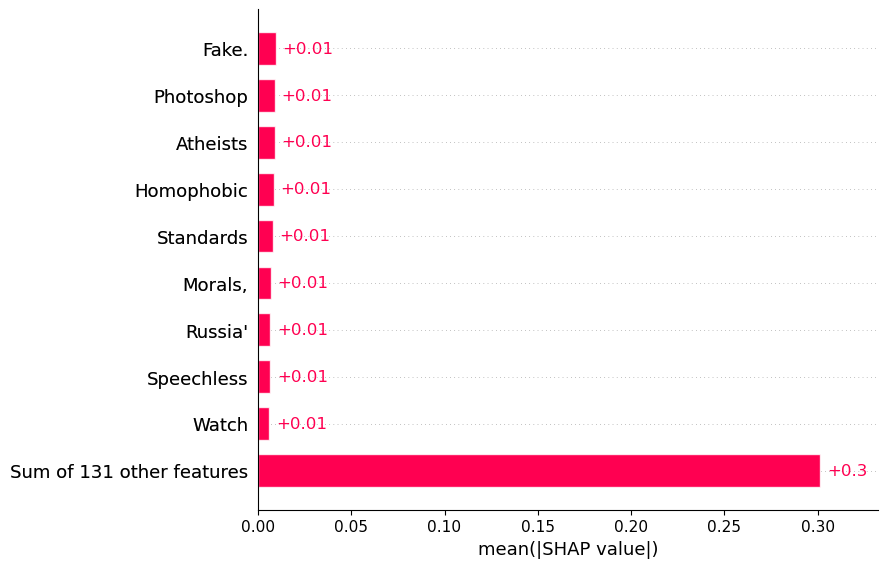

In [29]:
for i in range(5): #just checking for 5 of them for example
    shap.plots.text(top_shap_values_ridge[i])
shap.plots.bar(top_shap_values_ridge)

### 4.1.2 Checking for least 20 if there are words that had negative impact, because they will be the ones that will make the click rate lower

In [30]:
lowest_values = df.sort_values(["predictions_ridge"],ascending=True).loc[:,['headline']][:20]
lowest_values["headline"]
lowest_values = lowest_values.drop_duplicates(keep='first')
lowest_shap_values_ridge = explainer(lowest_values["headline"])


  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|██████                                                       | 2/20 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██████████▌                                          | 4/20 [00:25<01:42,  6.38s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|█████████████▎                                       | 5/20 [00:36<02:00,  8.01s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███████████████▉                                     | 6/20 [00:50<02:26, 10.44s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|██████████████████▌                                  | 7/20 [00:56<01:56,  8.97s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|█████████████████████▏                               | 8/20 [01:06<01:51,  9.30s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|██████████████████████████                          | 10/20 [01:25<01:27,  8.75s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|████████████████████████████████████▍               | 14/20 [01:48<00:32,  5.44s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████████████████████████████████████████▏       | 17/20 [02:08<00:17,  5.78s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████████████████████████████████████████████▍  | 19/20 [02:17<00:04,  4.89s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████| 20/20 [02:29<00:00,  6.90s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [02:46,  8.74s/it]                                                                  


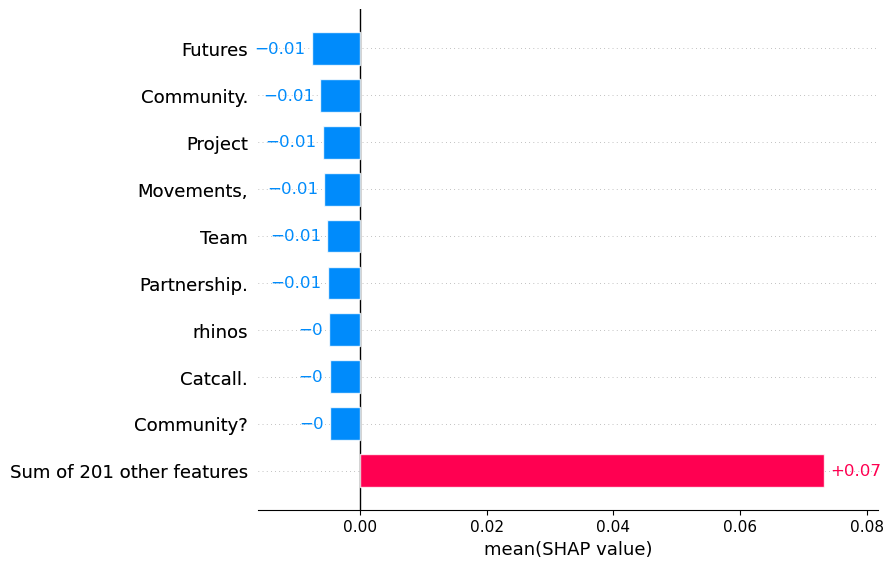

In [31]:
for i in range(5):
    shap.plots.text(lowest_shap_values_ridge[i])
shap.plots.bar(lowest_shap_values_ridge.mean(0),order=shap.Explanation.argsort)

## 4.2 Shapley Values Linear Regression predicting Clickrate

In [32]:
# load the model

# here we also need embeddings - the whole thing is our model
model = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2")

# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    embedding = model.encode(x)
    return linear_model.predict(embedding)

In [33]:
#defining masker - the masker specifies how to hide portions of the input
method = "default masker" #before it was custo tokenizer, but it works the same with the default one so i would say remove everything and just leave the defining of the whitespace masker

# build an explainer by passing a transformers tokenizer
if method == "transformers tokenizer":
    explainer = shap.Explainer(f)

# build an explainer by explicitly creating a masker
elif method == "default masker":
    masker  = shap.maskers.Text("\W|'")   # this will create a basic whitespace tokenizer.
    #A whitespace tokenizer breaks a text into tokens based on whitespace characters (spaces, tabs, newlines,/, etc.)
    explainer = shap.Explainer(f, masker)


### 4.2.1 Checking for shap values for top 20 predictions made with linear regression

In [34]:
top_values = df.sort_values(["predictions_linear"],ascending=False).loc[:,['headline']][:20]
#removing duplicates, so they dont influence the overall 
top_values = top_values.drop_duplicates(keep='first')
top_shap_values_linear = explainer(top_values["headline"])

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|███                                                          | 1/20 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|███████▉                                             | 3/20 [00:22<01:28,  5.22s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██████████▌                                          | 4/20 [00:31<01:50,  6.90s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███████████████▉                                     | 6/20 [00:48<01:40,  7.19s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|██████████████████▌                                  | 7/20 [00:56<01:36,  7.46s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|███████████████████████▊                             | 9/20 [01:13<01:23,  7.56s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|██████████████████████████                          | 10/20 [01:24<01:26,  8.65s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|████████████████████████████▌                       | 11/20 [01:32<01:17,  8.60s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|███████████████████████████████▏                    | 12/20 [01:45<01:18,  9.78s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|████████████████████████████████████▍               | 14/20 [01:58<00:47,  7.92s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████████████████████████████████████             | 15/20 [02:09<00:43,  8.66s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|██████████████████████████████████████████████▊     | 18/20 [02:26<00:12,  6.23s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████| 20/20 [02:39<00:00,  5.96s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [02:50,  8.51s/it]                                                                  


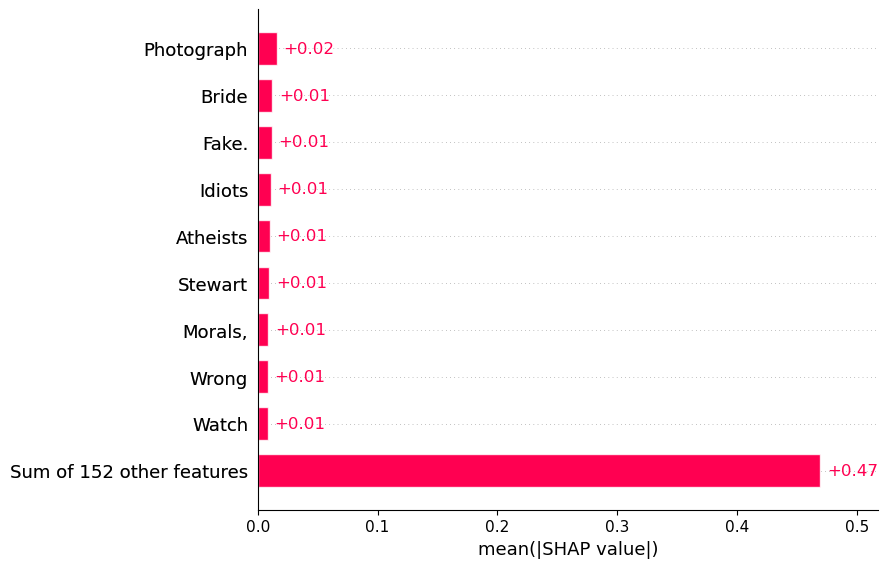

In [35]:
for i in range(5):
    shap.plots.text(top_shap_values_linear[i])
shap.plots.bar(top_shap_values_linear)

### 4.1.2 Checking for least 20 if there are words that had negative impact, because they will be the ones that will make the click rate lower

In [36]:
lowest_values = df.sort_values(["predictions_linear"],ascending=True).loc[:,['headline']][:20]
lowest_values = lowest_values.drop_duplicates(keep='first')
lowest_shap_values_linear = explainer(lowest_values["headline"])

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██████████▌                                          | 4/20 [00:19<00:30,  1.91s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███████████████▉                                     | 6/20 [00:36<01:12,  5.17s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|████████████████████████████▌                       | 11/20 [00:57<00:31,  3.52s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|███████████████████████████████▏                    | 12/20 [01:07<00:46,  5.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|█████████████████████████████████▊                  | 13/20 [01:23<01:01,  8.75s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|████████████████████████████████████▍               | 14/20 [01:36<01:00, 10.05s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████████████████████████████████████             | 15/20 [01:53<01:00, 12.15s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|█████████████████████████████████████████▌          | 16/20 [02:03<00:46, 11.59s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|██████████████████████████████████████████████▊     | 18/20 [02:22<00:19,  9.77s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████████████████████████████████████████████▍  | 19/20 [02:28<00:08,  8.89s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████| 20/20 [02:34<00:00,  8.00s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [02:49,  8.94s/it]                                                                  


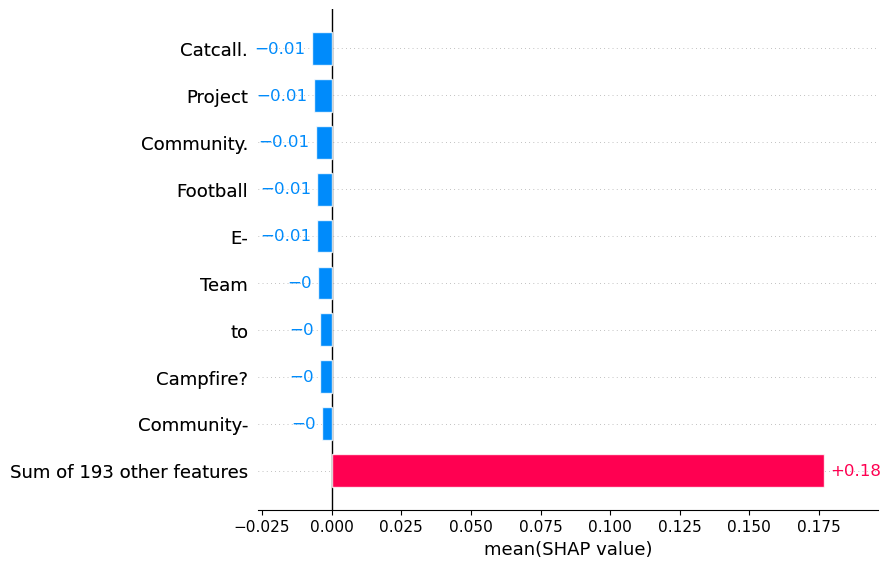

In [37]:
for i in range(5):
    shap.plots.text(lowest_shap_values_linear[i])
shap.plots.bar(lowest_shap_values_linear.mean(0),order=shap.Explanation.argsort)